In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,  as_frame= False)
mnist.keys()

c:\Users\iamuj\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- DESCR Key describes the dataset
- Data key contains an array with one row per instance and one column   per feature
- target key contains an array with the labels


In [3]:
X, y = mnist["data"], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

- 70,000 images and each image has 784 features
- 784 cuz the images are 28x28 pixels and each pixel represents intensity from 0 (white) to 1 (black)

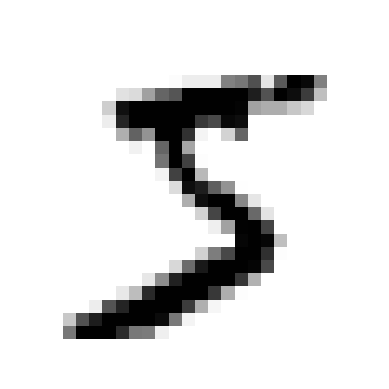

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

#### Get an instances feature vector and reshape it to 28x28 to display the image
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
## Cast string labels to integers
import numpy as np
y = y.astype(np.uint8)

In [7]:
#### Splitting the dataset into train and test sets, 60000 training and 10k test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training a Binary Classifier

In [8]:
### Trying to detect only one digit. The digit is 5 or not a 5.
y_train_5 = (y_train == 5)   ## True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sdg_clf = SGDClassifier()
sdg_clf.fit(X_train, y_train_5)

SGDClassifier()

In [10]:
sdg_clf.predict([some_digit]) ## Detecting the iamge of number 5 X[0]

array([ True])

Performance Measures

#### Cross Validation Implementatiom 

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sdg_clf)  ## At each iteration the code creates a clone of the classifier
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)  ## Trains the clone on the training folds 
    y_pred = clone_clf.predict(X_test_folds)  ## Makes prediction on the test folds
    n_correct = sum(y_pred == y_test_folds)  ## Counts the number of correct predictions
    print(n_correct/len(y_pred))  ## Ratio of correct predictions
    

0.86805
0.8804
0.88855


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sdg_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95245, 0.95845, 0.96425])

In [13]:
### Looking at a classifier that just classifies every single image in the "not a 5 class"
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring="accuracy")
### Gives pretty high accuracy. THats why accuracy is not a preferred performance measure

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict  ## Cross_val_predict performs K fold cross validation but instead of returning the evaluation scores, it returns the predictions made on each test fold
y_train_pred = cross_val_predict(sdg_clf, X_train, y_train_5, cv = 3)

In [16]:
## Getting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52573,  2006],
       [ 1739,  3682]], dtype=int64)

In [17]:
## Lets pretend we got perfection
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

- Acuuracy of positive predictions = PRECISION
- Precision = TP/(TP+FP)
- Ratio of positive instances that are correctly detected by the classifier = RECALL
- Recall = TP/(TP + FN)

#### Precision and Recall

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) ## 4565/(4566+2135)

0.6473277074542897

In [19]:
recall_score(y_train_5, y_train_pred)  ## 4565/(4565 + 856)

0.6792104777716288

when the classifier claims an image represents a 5, it is only correct 68% of the times and only detects 84% of the 5s

F1 Score is a Harmonic mean of precision and recall. HM gives much wt to low values. As a result, the classifier only get a high F1 score if both reacll and precision are high
- F1 = 2 x (precision x Recall) / (Precision + Recall)

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.6628859483301828

iF YOU trained a classifier to detect videos that are safe for kids, we prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in the product.

On the other hand if we are training a classifier to detect the shoplifters on surveillance images, it is prob fine if the classifier has only 30% precision as long as it has 99% recall( sure, the security guards will get a few false alerts but almost all the shoplifters will get caught)

Unfortunately we cant have it both ways, increasing precision reduces recall and vice versa. This is called precision recall tradeoff

In [21]:
### decicion_function() returns a  score of each instance, then make predictions based on those scores using any threshold we want
y_scores = sdg_clf.decision_function([some_digit])
y_scores

array([4997.6911884])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores < threshold)
y_some_digit_pred  ## SGDClassifier uses a threshold = 0 so this code returns the same result as the predict()

array([False])

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
### To decide which threshold to use we need to get the scores of all instances in the training set using corss_val_predict() again but this time specifying that we want it to return decision scores instead of predicitons
y_scores = cross_val_predict(sdg_clf, X_train, y_train_5, cv =3, method="decision_function")

In [25]:
y_scores

array([  5256.45375658, -25283.18364574, -32046.01435361, ...,
        10934.00328763,    705.10606562,  -8478.34071584])

Now with these scores we can compute precision and recall for all possible thresholds using `precision_recall_curve()`

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

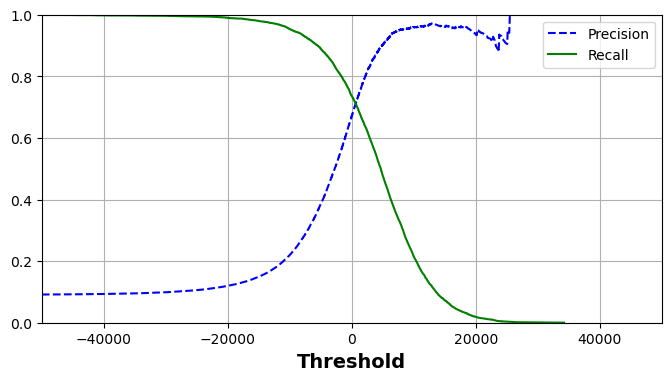

In [27]:
## Plotting precision and recall as functions of threshold value using matplotlib
def plot_precision_recall_vs_threshold(precisions, recalls, y_scores):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Threshold", fontsize = 14, fontweight = 'bold')
    plt.axis([-50000, 50000, 0, 1])

#recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
#threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")
plt.show()

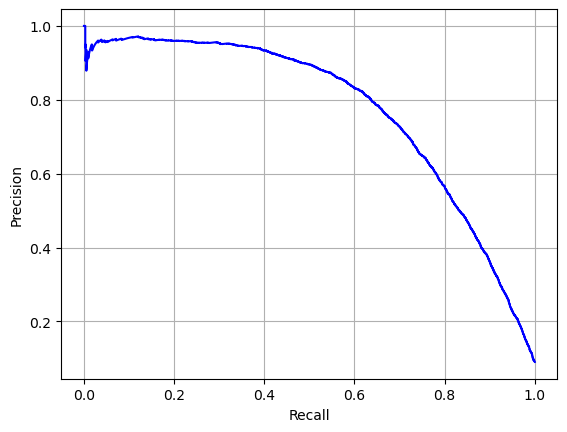

In [28]:
### ANother way to select a good precision/recal tradeoff is to plot precision directly against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
plot_precision_vs_recall(precisions, recalls)

Suppose we decide to aim for 90% precision. WE can search for the lowest threshold that gives at least 90% precision

In [29]:
## argmax gives the first index of the max value which in case means the first True Value
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.900137741046832

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4821988562995757

#### The ROC Curve
Roc curve plots the `True Positive rate` (RECALL) against `False Positive rate` 
- FPR is the ratio of negative instances that are incorrectly classified as positive
- FPR = 1 - TNR (specificity)
- TNR is ratio of negative instances that are correctly classified as negative
- ROC = Recall vs (1 - specificity)

In [33]:
## To plot ROC curve we need to compute the TPR and FPR for various threshold values using roc_curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

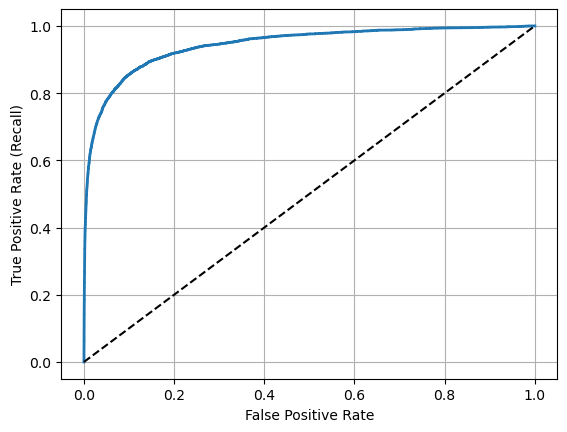

In [34]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--') ###dashed diagonal
    plt.grid(True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

plot_roc_curve(fpr, tpr)
plt.show()

A good classifier stays as far away from the line as possible (towards the top-left corner)

A way to compare clasifiers is to measure `area under the curve (AUC)`.
A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have ROC AUC = 0.5

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9439888246014565

In [36]:
### Training a Random Forest Classifier and comparing its ROC and ROC AUC curves TO SGDClassiier
## Random Forest has `dict_proba` instad of decision_function() for scores
##Classifiers generally have one or the other
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method='predict_proba')

In [37]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [38]:
## We need scores not probabilties for ROC curve. Simple solution is to use the positive clas probability as score
y_scores_forest = y_probas_forest[: , 1]  ## Score =  proba of +ve class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

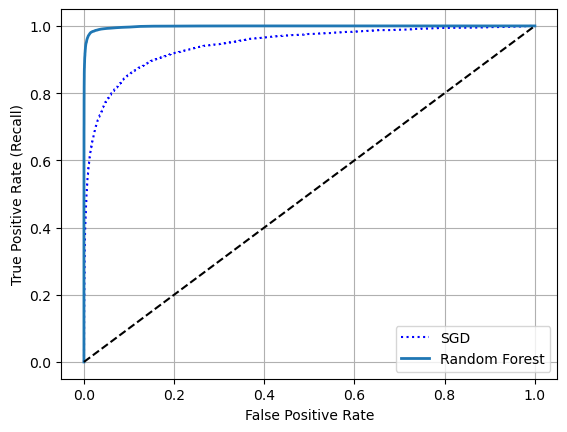

In [39]:
## Plotting the ROC curve
plt.plot(fpr, tpr, 'b:', label= "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

AS we can see the RandomForestClassifier ROC curve looks much better than SGDClassifier as it comes much cloe to the top left corner. As a result ROC AUC is also better

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

- Choose the approporiate metric for task 
- Evaluate the classifiers using cross validation 
- select precision/recall tradeoff that fits the needs
- compare various models using ROC curves and ROC AUC scores

#### MultiClass Classification

In [41]:
## Scikit learn detects when you try to use a binary classification algo for a multi class classification task and automatically rins OvA
sdg_clf.fit(X_train, y_train) ## y_train not y_train_5
sdg_clf.predict([some_digit])
### Under the hood, SCikit learn actaully trained 10 binary classifiers, got their decision scores for the image and selected the class with the highest score

array([3], dtype=uint8)

In [42]:
### get the decision scores
some_digit_scores = sdg_clf.decision_function([some_digit])
some_digit_scores

array([[-19074.46285285, -39876.99501399,  -8914.35745042,
          1028.93936896, -16736.1725894 ,    360.07101406,
        -20436.20720692, -20519.03711622,  -8737.41680569,
        -12520.78914694]])

In [46]:
np.argmax(some_digit_scores)

3

In [44]:
sdg_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
sdg_clf.classes_[3]

3

Forcing Scikit Learn to use on versus one or one versus all 

In [47]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
len(ovo_clf.estimators_) ### returns the no of 1v1s classifiers 

45

In [51]:
### Training a random forest classifier, this time random forest did not have to run ovA or ovo cuz random forest classifier directly classifies instances into multiple classes
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [53]:
### 0.9 at the 5th index means that the model estimates  a 90% prob that the image represents a 5

In [54]:
### Evaluating sgd classifier accuracy with cross val score
cross_val_score(sdg_clf, X_train, y_train, cv = 3, scoring="accuracy")

array([0.83275, 0.8765 , 0.88785])

In [55]:
#### Simply scaling the inputs increases accuracy 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sdg_clf, X_train_scaled, y_train, cv = 3, scoring="accuracy")

c:\Users\iamuj\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9005, 0.8926, 0.9083])

#### Error Analysis

In [56]:
y_train_pred = cross_val_predict(sdg_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5579,    0,   21,    6,    8,   49,   38,    6,  216,    0],
       [   0, 6395,   39,   23,    4,   46,    4,    7,  212,   12],
       [  27,   26, 5227,   92,   71,   27,   66,   38,  377,    7],
       [  23,   16,  116, 5222,    2,  209,   27,   38,  406,   72],
       [  12,   14,   46,    9, 5187,   14,   35,   27,  336,  162],
       [  29,   15,   30,  165,   52, 4436,   76,   14,  544,   60],
       [  29,   15,   43,    3,   43,   96, 5551,    4,  133,    1],
       [  21,    9,   51,   30,   50,   15,    3, 5687,  190,  209],
       [  18,   62,   45,   88,    3,  130,   25,   10, 5429,   41],
       [  25,   18,   31,   63,  118,   32,    1,  180,  381, 5100]],
      dtype=int64)

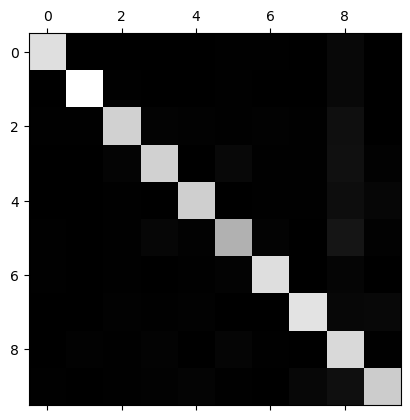

In [57]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

This conf matrix looks fairly good, since most images are on the main diagonal, which means they were classified correctly. The 5s look slightly darker than the other digits. In fact, you can verify that both are the case.

WE need to divide each value in the conf matrix by the no. of images in the corresponding class, so we can compare error rates instead of absolute number of errors 

In [58]:
row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

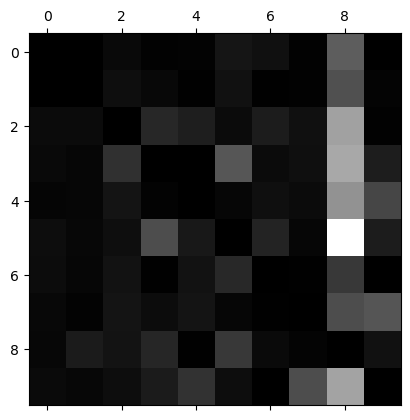

In [59]:
### Now lets fill the diagonal with zeros to keep only the errors and lets plot the result
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Row represents actual classes, while column represents predicted classes.
Column 8 is quite bright, meaning that many images get misclassified as 8.
However row is not that bad, meaning 8s in general get properly classified as 8.
- we can also see 3 and 5 often get confused. ref pg 132 on more error analysis

In [64]:
import matplotlib.pyplot as plt
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

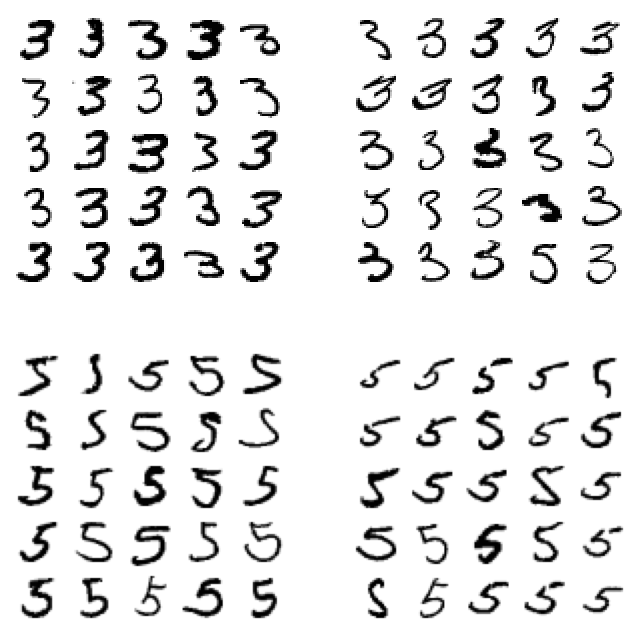

In [65]:
# plotting 3s and 5s 
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

#### MultiLabel Classification

In [81]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] ### Two o/p classes 1st - digit is 7,8,9 and 2nd if its odd or not

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [84]:
#knn_clf.predict([some_digit])

In [85]:
## Computing average F1 scores across all labels
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
#f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [86]:
### Adding and removing noise
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [88]:
# some_index = 20
# knn_clf.fit(X_train_mod, y_train_mod)
# clean_digit = knn_clf.predict([X_test_mod[some_index]])
# plot_digits(clean_digit)